# Riofreddo
We want to extract the 2m air temperature and the relative humidity over Riofreddo, a village 45 km north-east of Rome, between May 27th and July 5th 2024. The coordinates of the village are: latitude = 42.0615275803612, longitude = 12.999685358882479. We use the [Copernicus ERA5-Land hourly data from 1950 to present](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-land) as data source. We download the data manually from the Copernicus website (at the time of development the web API did not work). The dataset does not provide directly the relative humidity but it does provide the 2m dew point temperature from which we can calculate the relative humidity.   

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cdsapi
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)
print("xarray version: %s"%xr.__version__)
print("matplotlib version: %s"%matplotlib.__version__)
print("cartopy version: %s"%cartopy.__version__)

python version: 3.11.5
pandas version: 2.1.1
xarray version: 2023.12.0
matplotlib version: 3.8.0
cartopy version: 0.22.0


The spatial resolution of the data is 0.1°x0.1° so we select a bounding box around the given point location.

In [2]:
bb_north = 42.20
bb_south = 41.80
bb_west = 12.80
bb_east = 13.10

In [3]:
month = 'june'
DATADIR = 'data/riofreddo'
WDIR = f'era5_land_riofreddo_{month}_2024'

In [4]:
with ZipFile(f'{DATADIR}/{WDIR}.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/{WDIR}/')

In [5]:
riofreddo_ds = xr.open_dataset(f'{DATADIR}/{WDIR}/data_0.nc')
riofreddo_ds

<xarray.Dataset>
Dimensions:     (valid_time: 720, latitude: 5, longitude: 4)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2024-06-01 ... 2024-06-30T23:00:00
  * latitude    (latitude) float64 42.2 42.1 42.0 41.9 41.8
  * longitude   (longitude) float64 12.8 12.9 13.0 13.1
    expver      (valid_time) <U4 ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 ...
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-08-22T16:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
temperature_da = riofreddo_ds['t2m']
dew_point_da = riofreddo_ds['d2m']
lats = riofreddo_ds['latitude']
lons = riofreddo_ds['longitude']

## Time series of the 2m air temperature in Riofreddo

Text(0.5, 1.0, 'ERA5-Land 2 meter air temperature - 2022-06-30T15:00:00')

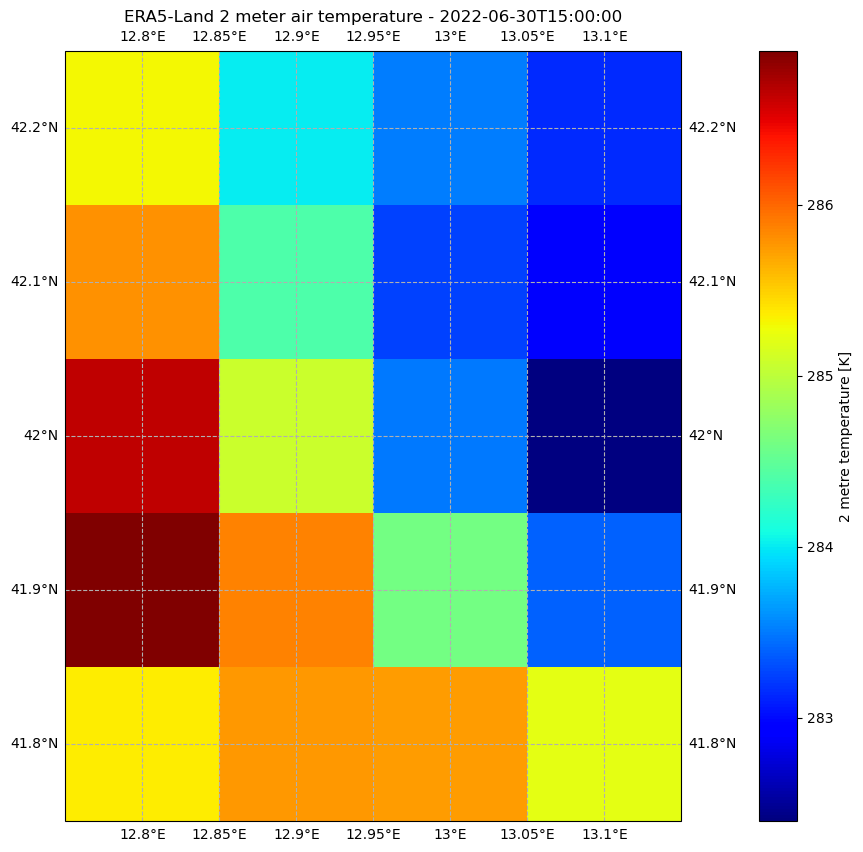

In [8]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linestyle='--')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
temperature_da.sel(valid_time='2024-06-01T00:00:00').plot(ax=ax, add_colorbar=True, cmap='jet')
plt.title('ERA5-Land 2 meter air temperature - 2022-06-30T15:00:00')

In [22]:
riofreddo_temperature_da = temperature_da.sel(latitude = 42.0615275803612, longitude = 12.999685358882479, method='nearest')
riofreddo_temperature_da

<xarray.DataArray 't2m' (valid_time: 720)>
[720 values with dtype=float32]
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2024-06-01 ... 2024-06-30T23:00:00
    latitude    float64 42.1
    longitude   float64 13.0
    expver      (valid_time) <U4 ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      20
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

Text(0.5, 0.98, '2 meter air temperature - Riofreddo (RM), June 2024 (K)')

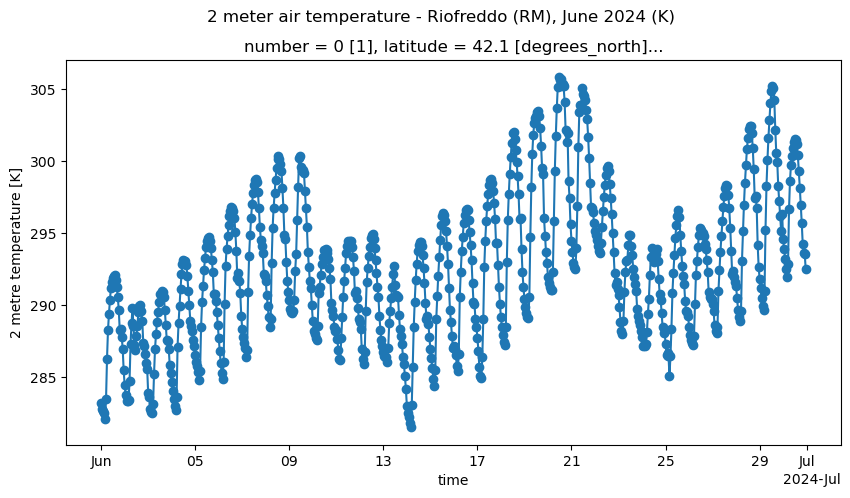

In [23]:
fig = plt.figure(figsize=(10, 5))
riofreddo_temperature_da.plot(marker='o')
plt.suptitle("2 meter air temperature - Riofreddo (RM), June 2024 (K)")

## Time series of the 2m dew point temperature in Riofreddo

In [10]:
riofreddo_dew_point_da = dew_point_da.sel(latitude = 42.0615275803612, longitude = 12.999685358882479, method='nearest')
riofreddo_dew_point_da

<xarray.DataArray 'd2m' (valid_time: 720)>
[720 values with dtype=float32]
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2024-06-01 ... 2024-06-30T23:00:00
    latitude    float64 42.1
    longitude   float64 13.0
    expver      (valid_time) <U4 ...
Attributes: (12/32)
    GRIB_paramId:                             168
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      20
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre dewpoint temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

Text(0.5, 0.98, '2 meter Dew point temperature - Riofreddo (RM), June 2024 (K)')

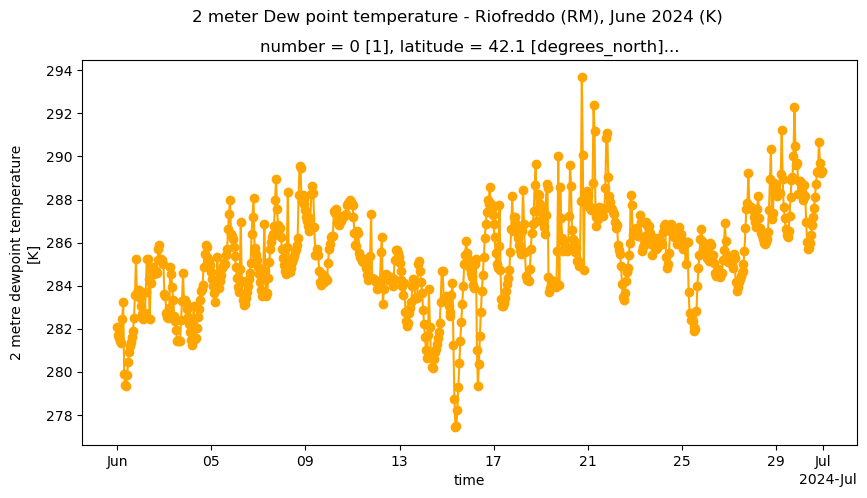

In [26]:
fig = plt.figure(figsize=(10, 5))
riofreddo_dew_point_da.plot(marker='o', color='orange')
plt.suptitle("2 meter Dew point temperature - Riofreddo (RM), June 2024 (K)")

## Transformation from dew point temperature to relative humidity RH.
In order to transform the dew point temperature $T_d$ into relative humidity RH we use the formula

$$RH = \frac{e_s(T_d)}{e_s(T)}$$

where $e_s$ is the water vapor pressure at saturation, in Pa. The water vapor pressure at saturation can be computed from the [Clausis-Clapeyrom equation](https://en.wikipedia.org/wiki/Clausius%E2%80%93Clapeyron_relation). To make the calculation easier we can use an approximation such as the August-Roche-Magnus approximation.

$$ e_s(T) = c * exp(\frac{aT}{b + T}) $$

where a, b and c are constants and T is the air temperature in °C.

In [9]:
a = 17.625
b = 243.04
c = 6.1094

def saturated_water_pressure(T):
    return c * np.exp(a * T / (b + T))

We transform the data from Kelvin to Celsius

In [32]:
riofreddo_dew_point_celsius = riofreddo_dew_point_da - 273.15
riofreddo_temperature_celsius = riofreddo_temperature_da - 273.15

In [33]:
sat_wvp_dew_point = xr.apply_ufunc(saturated_water_pressure, riofreddo_dew_point_celsius)
sat_wvp_air_temp = xr.apply_ufunc(saturated_water_pressure, riofreddo_temperature_celsius)

In [34]:
riofreddo_rh = sat_wvp_dew_point / sat_wvp_air_temp   

Text(0.5, 0.98, 'Relative humidity - Riofreddo (RM), June 2024 (K)')

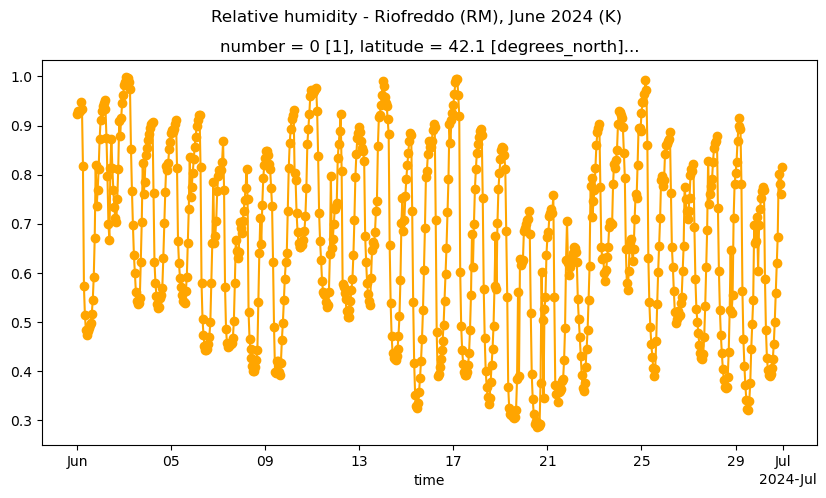

In [35]:
fig = plt.figure(figsize=(10, 5))
riofreddo_rh.plot(marker='o', color='orange')
plt.suptitle("Relative humidity - Riofreddo (RM), June 2024 (K)")

## References
* [National Physical Laboratory - How do I convert between dew point and relative humidity?](https://www.npl.co.uk/resources/q-a/dew-point-and-relative-humidity)
* [Stull - Practical Meteorology: An Algebra-based Survey of Atmospheric Science](https://www.eoas.ubc.ca/books/Practical_Meteorology/)